# SidewalkSim
Use this jupyter notebook to test ideas related to the SidewalkSim program.

Use Python 3.7+


The following thrid-party packages are used in the SidewalkSim module, need to install those packages before start.
```python
import pandas as pd
import numpy as np
import geopandas as gpd
from shapely.geometry import Point

import networkx as nx

import matplotlib.pyplot as plt
```

# Set up

Import useful modules/packages for this notebook.

Auto-load external packages (SidewalkSim) for debugging/interaction.

In [1]:
import os

import numpy as np
import pandas as pd
import geopandas as gpd
import networkx

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/%autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2
pd.options.display.max_columns = None  # display all columns

In [2]:
# import SidewalkSim module
from Run_package.SidewalkSim.core_script.getPaths_sidewalkSim import *

In [3]:
# need to set this environmental path everytime you moves the project root folder
os.environ['PROJ_LIB'] = os.path.join(os.getcwd(), 'Run_package/SidewalkSim')

In [40]:
use_impedance = True
cols = ['None','Some','Device','WChairM','WChairE','MScooter','LowVision','Blind']

## File Import (not required)

In [34]:
# Import network files
sidewalk = gpd.read_file(os.path.join(os.environ['PROJ_LIB'], 'sidewalk_raw_files/sidewalks_071724.shp'))
crosswalk = gpd.read_file(os.path.join(os.environ['PROJ_LIB'], 'sidewalk_raw_files/crosswalks_071724.shp'))
nodes = gpd.read_file(os.path.join(os.environ['PROJ_LIB'], 'sidewalk_raw_files/sidewalkNodes.shp'))

In [36]:
cols_names = {
    'sidewalk': {'stmAdaPa_3': 'sid1', 'stmAdaPa_4': 'sid2'},
    'crosswalk': {'stmAdaPa_2': 'InterID_t', 'stmAdaPa_3': 'sid1', 'stmAdaPa_4': 'sid2'},
    'nodes': {'stmAdaPath': 'sid', 'stmAdaPa_1': 'lat', 'stmAdaPa_2': 'lon'}
}
# Fixing column names
sidewalk = sidewalk.rename(columns=cols_names['sidewalk'])
crosswalk = crosswalk.rename(columns=cols_names['crosswalk'])
nodes = nodes.rename(columns=cols_names['nodes'])
# Reproject
sidewalk = sidewalk.to_crs('EPSG:2240')
crosswalk = crosswalk.to_crs('EPSG:2240')
nodes = nodes.to_crs('EPSG:2240')
# Format data types
sidewalk['sid1'] = sidewalk['sid1'].astype(np.int64).astype(str)
sidewalk['sid2'] = sidewalk['sid2'].astype(np.int64).astype(str)
crosswalk['sid1'] = crosswalk['sid1'].astype(np.int64).astype(str)
crosswalk['sid2'] = crosswalk['sid2'].astype(np.int64).astype(str)
nodes['sid'] = nodes['sid'].astype(np.int64).astype(str)

<Axes: >

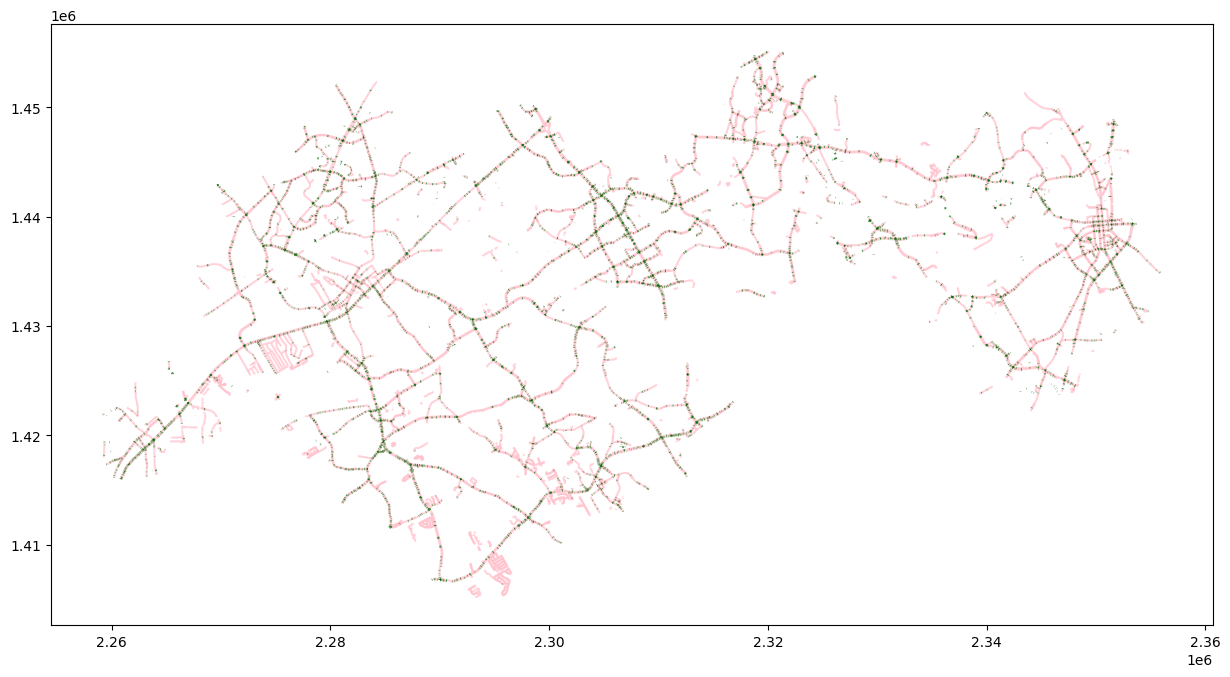

In [37]:
# Let's have a look at the network
fig, ax = plt.subplots(figsize=(15, 15))
sidewalk.plot(ax=ax, alpha=0.7, color="pink", zorder=1)
crosswalk.plot(ax=ax, alpha=0.7, color='darkgreen', zorder=2)
# nodes.plot(ax=ax, alpha=0.5, color='teal', zorder=0)

# Let's Run SidewalkSim!

## Data Preparation
Merge node information into the link dataset. Two left joins are needed since each link has two end nodes. The node columns are renamed to the following naming rules **("A" stands for origin node and "B" stands for end node)**: 
```Python
columns={'N': 'A', 'X': 'Ax', 'Y': 'Ay', 'lat': 'A_lat', 'lon': 'A_lon'}
columns={'N': 'B', 'X': 'Bx', 'Y': 'By', 'lat': 'B_lat', 'lon': 'B_lon'}
```
Output the merged file to is 'data_node_link/abm15_links.shp'

Can do this step everytime you run the program, or you can skip this step by read the "abm15_links.shp" file (see commented try except code) if network doesn't change between two runs. (It only takes a few seconds to merge data on my laptop, so there is actually no efficiency issue)

In [41]:
print('** Initialize sidewalk network **')
t1 = time.time()
dirPath = os.path.join(os.environ['PROJ_LIB'], 'build_graph')
os.chdir(dirPath)
# os.environ['PROJ_LIB'] = os.getcwd()  # since the notebook is at main directory
# try:
#     sw_links = gpd.read_file(os.path.join(os.environ['PROJ_LIB'],
#                                           'build_graph', 'data_node_link', 'SWS_sw_links.shp'))
#     cw_links = gpd.read_file(os.path.join(os.environ['PROJ_LIB'],
#                                           'build_graph', 'data_node_link', 'SWS_cw_links.shp'))
# except:
df_links = initialize_sws_links()
# integrate impedance if needed
if use_impedance:
    impedance = pd.read_csv(os.path.join(os.environ['PROJ_LIB'], 'sidewalk_raw_files/impedance_072224.csv'))
    impedance['A_B'] = impedance.apply(lambda x: str(x['Upstream Node']) + '_' + str(x['Downstream Node']), axis=1)
    impedance = impedance[['A_B'] + cols]
    df_links = df_links.merge(impedance, how='left', on='A_B')
# print some information
display(df_links.head(2))
print(df_links.shape)
print('It takes {} min to generate preprocess data.'.format(round((time.time()-t1)/60,2)))

** Initialize sidewalk network **


footway  stmAdaPath  stmAdaPa_1 stmAdaPa_2           A           B  \
0  sidewalk    0.246870  444.365488  271854236  2767961836  2767961843   
1  sidewalk    0.124509  224.117009  272205759  2771531501  2771531516   

   stmAdaPa_5  stmAdaPa_6  stmAdaPa_7  stmAdaPa_8  Shape_Leng  \
0   33.983528  -84.083604   33.986815  -84.083326  397.298281   
1   33.972055  -84.149667   33.970873  -84.148081  200.378580   

                                            geometry      type InterID_t  \
0  LINESTRING (2321761.955 1449078.115, 2321749.8...  sidewalk        -1   
1  LINESTRING (2301737.179 1444893.58, 2301759.52...  sidewalk        -1   

             Ax            Ay      A_lon      A_lat            Bx  \
0  2.321762e+06  1.449078e+06 -84.083604  33.983528  2.321845e+06   
1  2.301737e+06  1.444894e+06 -84.149667  33.972055  2.302218e+06   

             By      B_lon      B_lat  minx_sq  miny_sq  maxx_sq  maxy_sq  \
0  1.450274e+06 -84.083326  33.986815     93.0     58.0     93.0     58.0   
1  1.444463e+06 -84.148081  33.970873     92.0     58.0     92.0     58.0   

      distance                    A_B        None        Some      Device  \
0  1303.469725  2767961836_2767961843  355.492390  444.365489  592.487320   
1   657.408866  2771531501_2771531516  179.293608  224.117010  298.822676   

      WChairM     WChairE    MScooter   LowVision       Blind  
0  296.243658  222.182744  177.746195  444.365489  592.487320  
1  149.411340  112.058503   89.646804  224.117010  298.822676

(14073, 36)
It takes 0.02 min to generate preprocess data.


`dict_settings` are for the settings of all general information before running SidewalkSim. This includes the general information like walking speed, walking threshold, etc. **Notice that query time and strategy together *jointly* defines the trip's information**, either by the departure time or by arrival time.

For example, for strategy set to 1, given departure time (**`query_time`**) is 7:30 and the estimated travel time by the program is 40 minutes, one can calculate the arrival time as 8:10. The same travel plan used for strategy 2 would be: given arrival time (**`query_time`**) at 10:00, the departure time should be 9:20.

The code block below is: **Given departure time from origin, solve earliest arrival time**. The opposite strategy is run in later part of this notebook.

Either set query time and strategies directly in the ```dict_settings```, or read data files of those settings to apply different strategies in the same run. 

Load data. If contains temporal information.

** build walking network **
It takes 0 min to generate analysis graph.
** load trip data & prepare sample **
**for each trip, find k-shortest paths**
seq
['11382130590_11382130591', '11142735220_11382130590', '11142735219_11142735220', '11142735219_11382130585', '11382130584_11382130585', '11382130584_5987270022', '11417735627_5987270022', '11417735625_11417735627', '11417735625_5987163864', '11382130581_5987163864', '11382130580_11382130581', '11382130578_11382130580', '11382130578_11382130579', '10782469502_11382130579', '10782469502_11417735623', '11382130577_11417735623', '11382130576_11382130577', '11382130576_5987163859', '11406239363_5987163859', '11406239362_11406239363', '10052651843_11406239362', '10052651843_5987155585', '11417735638_5987155585', '11406284681_11417735638', '11406284681_5987155615', '5987155615_5987155620', '11479351648_5987155620', '11479351648_11479351649', '11479351649_5987155622', '10088192966_5987155622', '10088192966_5987163805', '5987163805_7320169668'

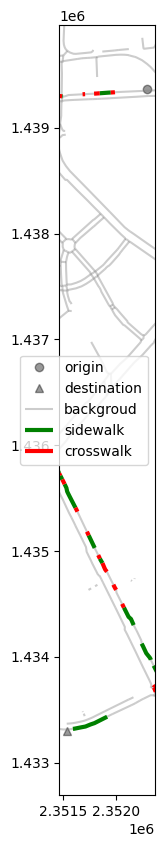

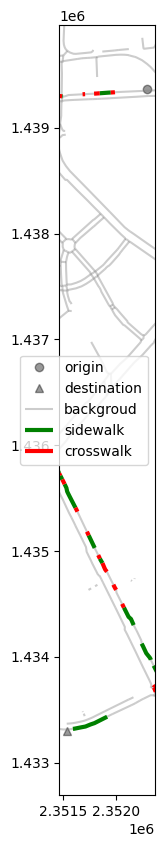

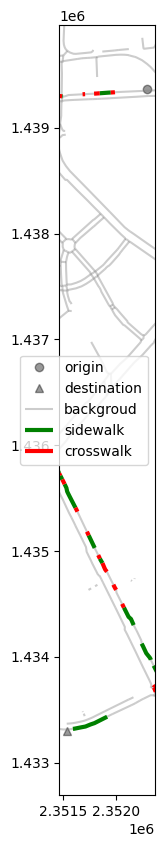

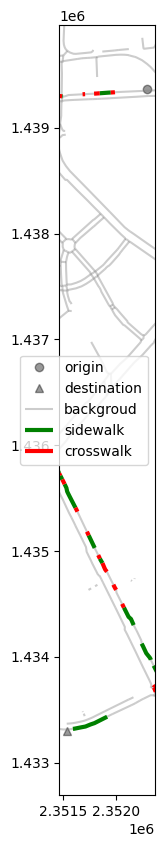

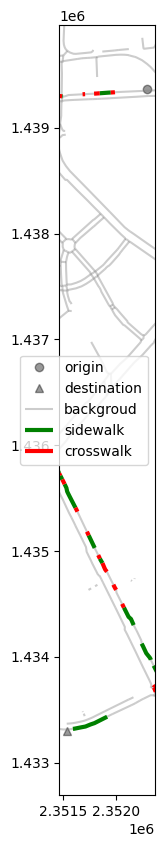

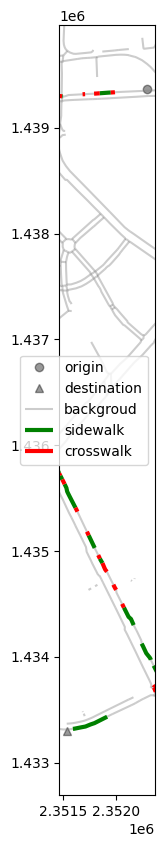

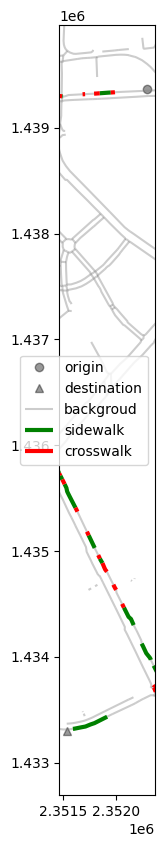

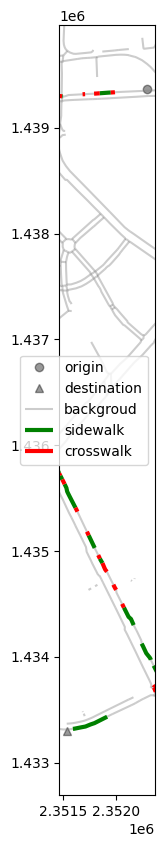

In [43]:
for col in cols:
    # build networkx graph takes several minutes
    t1 = time.time()
    print('** build walking network **')
    if use_impedance:
        dict_walk = {'DG': build_walk_network_impedance(df_links, col), 'links': df_links}
    else: 
        dict_walk = {'DG': build_walk_network(df_links), 'links': df_links}
    print('It takes {} min to generate analysis graph.'.format(round((time.time()-t1)/60), 2))

    ### combine all settings in a dictionary
    dict_settings = {}
    
    # strategy: 1. given origin time find earliest arrival
    #           2. given expected arrival time find latest departure time
    dict_settings = {'walk_speed': 2.5,  # people's walking speed 2.5 mph
                     'grid_size': 25000.0,  # for searching nearby links by grouping links to grids with width 25000 ft. for efficiency in searching
                     'ntp_dist_thresh': 5280,  # node to point (maximum distance access to network from origin/destination);
                     'network': {'sidewalk': dict_walk},  # dump in networks and modes
                     # strategy determines network link's direction.
                     # Strategy 1: Find earliest arrival given query time as departure time
                     # Strategy 2: Find latest departure time given query time as arrival time
                     'strategy': {'sidewalk': 1},  # 1. find earliest arrival 2. find latest departure
                     'query_time': [8],  # departure time or arrival time of a trip, depends on the strategy
                     'walk_thresh': {'sidewalk': 1},  # walking threshold is 1 mile (IGNORED by the Sidewalk option)
                     'num_options': {'sidewalk': 1},  # if set to 2, return 2 shortest paths
                     'plot_all': True,  # if True, plot results and save plots for all routes found
                     'one_by_one': False,  # set time and strategy one by one
                     'plot_limit': True # if True, the plots will be created to center around samples
                     }

    ### Create samples
    print('** load trip data & prepare sample **')
    sample_Prepared = True  # check prepared process
    options = ['sidewalk']
    
    df_points = pd.DataFrame()
    # Section 2: lOAD SAMPLE DATA; could have multiple csv sample files.
    if dict_settings['one_by_one'] is False:
        if sample_Prepared:
            for samp_file in glob.glob(os.path.join('samples_out', '*.csv')):
                dfi = pd.read_csv(samp_file)
                dfi['sample'] = os.path.basename(samp_file).split('.csv')[0]
                df_points = pd.concat([df_points, dfi], ignore_index=True)
        else:
            for samp_file in glob.glob(os.path.join('samples_in', '*.csv')):
                dfi = samp_pre_process(samp_file, dict_settings, option='sidewalk')
                df_points = pd.concat([df_points, dfi], ignore_index=True)
    else:
        if sample_Prepared:
            for samp_file in glob.glob(os.path.join('one_by_one_out', '*.csv')):
                dfi = pd.read_csv(samp_file)
                dfi['sample'] = os.path.basename(samp_file).split('.csv')[0]
                df_points = pd.concat([df_points, dfi], ignore_index=True)
        else:
            for samp_file in glob.glob(os.path.join('one_by_one_in', '*.csv')):
                dfi = samp_pre_process(samp_file, dict_settings, option='sidewalk')
                df_points = pd.concat([df_points, dfi], ignore_index=True)

    ### All run
    print('**for each trip, find k-shortest paths**')
    if not use_impedance:
        col = None
    allRun(df_points, options, dict_settings, os.environ['PROJ_LIB'], use_impedance, col)

<Axes: >

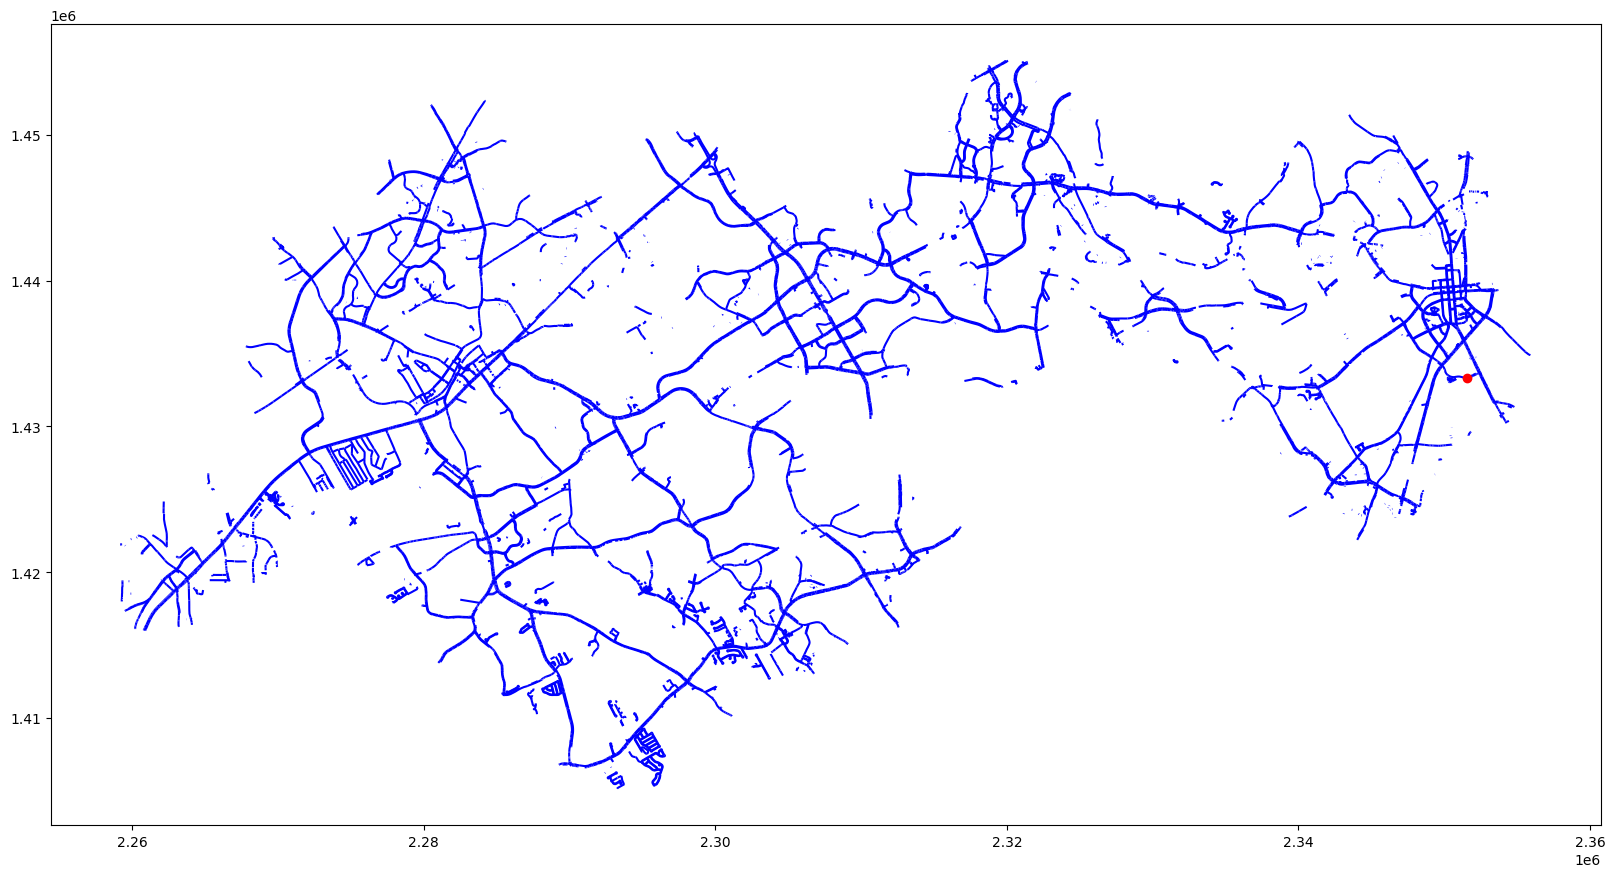

In [44]:
df_points_plot = df_points.copy()
df_points_plot = gpd.GeoDataFrame(df_points_plot, 
                                  geometry = gpd.points_from_xy(df_points_plot.dx, df_points_plot.dy))
base = df_links.plot(color='blue', figsize = (20,20), zorder=0)
df_points_plot.plot(ax = base, color='red', zorder=1)

In [44]:
df_links = df_links_bk.copy()

In [45]:
# Integrate mode
df_links['mode'] = 'crosswalk'
df_links.loc[df_links['InterID_t']==-1, 'mode'] = 'sidewalk'
# Format df_links to match the trajecotries file
df_links = df_links.to_crs('EPSG:4326')
df_links['A'] = df_links['A'].astype(str)
df_links['B'] = df_links['B'].astype(str)
# Integrate impedance
impedance = pd.read_csv(os.path.join(os.environ['PROJ_LIB'], 'sidewalk_raw_files/impedance_20240709.csv'))
impedance = impedance[['Upstream Node', 'Downstream Node', 'Way Id']]
impedance.columns = ['A', 'B', 'Way Id']
impedance = impedance.astype(str)
df_links = df_links.merge(impedance, how='left', on=['A', 'B'])
# Reverse the links to get bi-directional
df_links_rev = df_links.rename(columns={'A':'B', 'B':'A'}) ########## key to solve the intermittent lines problem
df_links = pd.concat([df_links, df_links_rev], ignore_index=True).drop_duplicates()
# Get nodes coordinates
nodes = df_links[['A', 'A_lat', 'A_lon']].drop_duplicates()
nodes.columns = ['node','lat','lon']
nodes = nodes.drop_duplicates(subset=['node'], keep='first')
# Get links geometry

In [46]:
from shapely.geometry import LineString, Point
from tqdm import tqdm

In [47]:
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import LineString, Point
import contextily as ctx
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

def plot_polished_sws_traj(df_traj, color_map, saveLoc, saveShp=False):
    """
    Plot a polished trajectory with annotated data over a basemap.

    Args:
    df_traj (DataFrame): DataFrame containing trajectory data with columns 'geometry', 'mode', 'time', and 'dist'.
    color_map (dict): Dictionary mapping modes to color values.
    saveLoc (str): File path where the plot will be saved.

    Returns:
    bool: True if the plot was created and saved successfully, False otherwise.
    """
    # Convert DataFrame to GeoDataFrame and set CRS
    gdf_traj = gpd.GeoDataFrame(df_traj, geometry=df_traj['geometry'], crs="EPSG:4326")
    # Save if needed
    if saveShp:
        saveshpLoc = saveLoc.replace('results_route_polished', 'results_route_shp')
        gdf_traj.to_file(os.path.join(saveshpLoc, f'{str(df_traj.iloc[0].trip_id)}.shp'))
    #
    gdf_traj = gdf_traj.to_crs(epsg=3857)
    
    # Plot setup
    fig, ax = plt.subplots(figsize=(20, 20))
    
    # Plot each line with mode-based color
    for _, row in gdf_traj.iterrows():
        if row['mode'] in color_map:
            line = gpd.GeoSeries(row['geometry'], crs="EPSG:3857")
            line.plot(ax=ax, color=color_map[row['mode']], linewidth=2)
    
        # Add annotations for impedance and travel time
        way_id = str(row['Way Id'])
        midpoint = row['geometry'].interpolate(0.5, normalized=True)
        impedance = f"{round(row['time']*60)}"
        travel_time = f"{(row['dist'] / 2.5 * 60):.2f} min"
        #plt.annotate(f'ID={way_id}\n IT(sec)={impedance}', (midpoint.x, midpoint.y),
        #             textcoords="offset points", xytext=(0,5), ha='center', color='black')
        '''
        # This option is for plotting the long impedance name
        plt.annotate(f'{impedance}\n{travel_time}', (midpoint.x, midpoint.y),
                     textcoords="offset points", xytext=(0,5), ha='center', color='black')
        '''
    
    # Mark origins and destinations
    origin = Point(gdf_traj.iloc[0]['geometry'].coords[0])
    destination = Point(gdf_traj.iloc[-1]['geometry'].coords[-1])
    gpd.GeoDataFrame({'geometry': [origin]}, geometry='geometry').plot(ax=ax, marker='o', color='black', markersize=20)
    gpd.GeoDataFrame({'geometry': [destination]}, geometry='geometry').plot(ax=ax, marker='s', color='black', markersize=20)
    
    # Set bounds with padding
    bounds = gdf_traj.total_bounds
    padding = 100  # meters if your CRS is in meters
    ax.set_xlim(bounds[0] - padding, bounds[2] + padding)
    ax.set_ylim(bounds[1] - padding, bounds[3] + padding)
    
    # Add basemap
    ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik, alpha=0.5)
    
    # Add legend
    legend_elements = [
        Patch(facecolor=color_map['sidewalk'], label='Sidewalk'),
        Patch(facecolor=color_map['crosswalk'], label='Crosswalk'),
        Patch(facecolor=color_map['ingress'], label='Ingress/Egress'),
        Line2D([0], [0], marker='o', color='w', label='Origin', markerfacecolor='black', markersize=10),
        Line2D([0], [0], marker='s', color='w', label='Destination', markerfacecolor='black', markersize=10),
        Line2D([0], [0], color='white', label='Way ID, Impedance (seconds)')
    ]
    
    ax.axis('off')
    ax.legend(handles=legend_elements, loc='upper right')
    p_save = os.path.join(saveLoc, f'{str(df_traj.iloc[0].trip_id)}.PNG')
    plt.savefig(p_save, format='png', dpi=300, bbox_inches='tight', pad_inches=0)

    return True

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.26s/it]


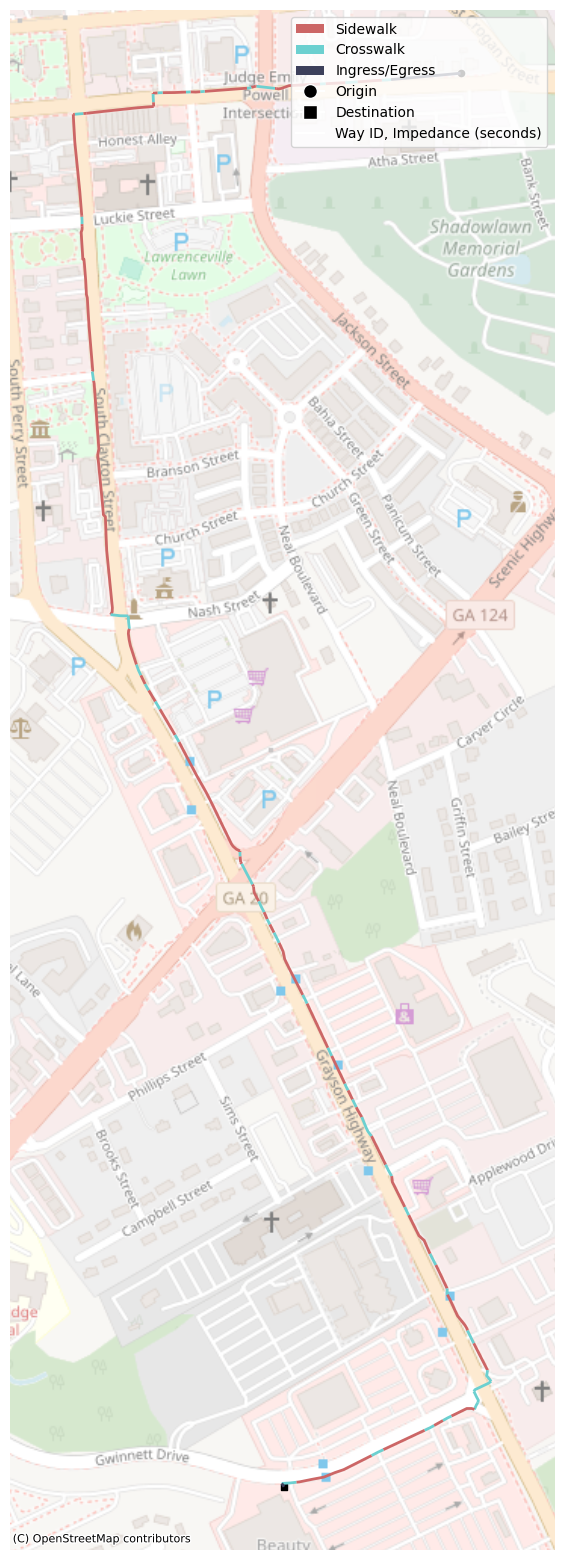

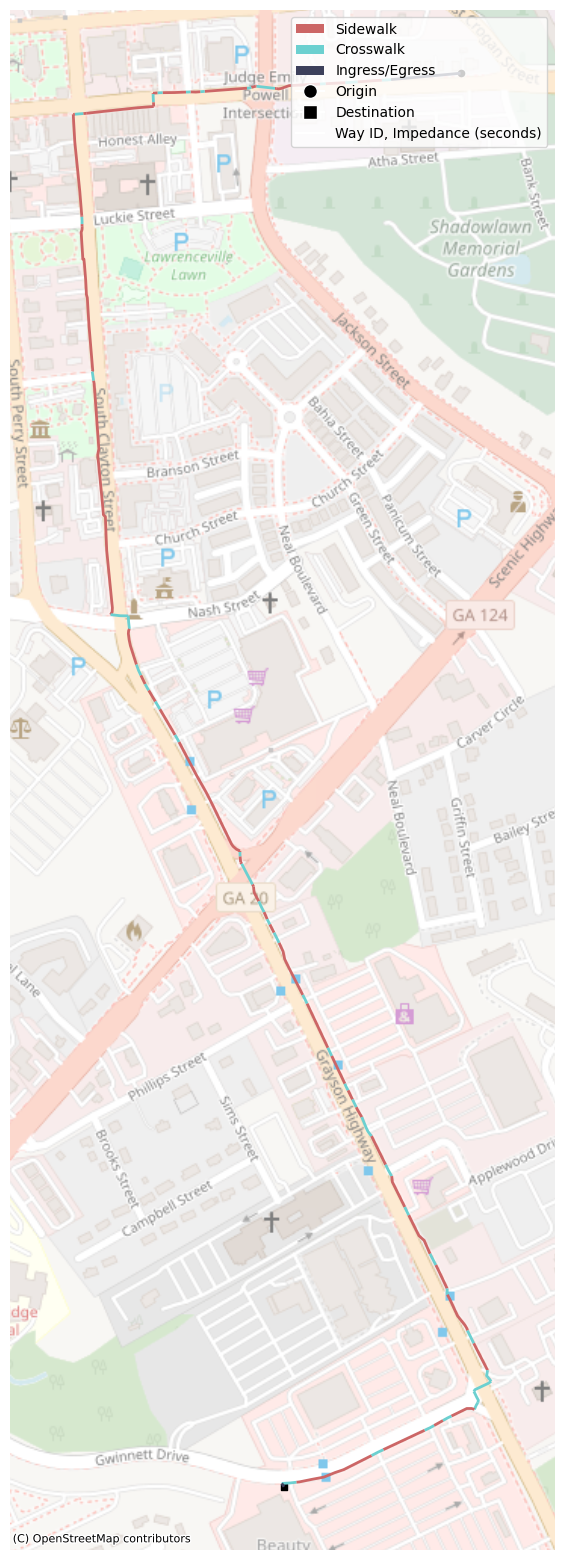

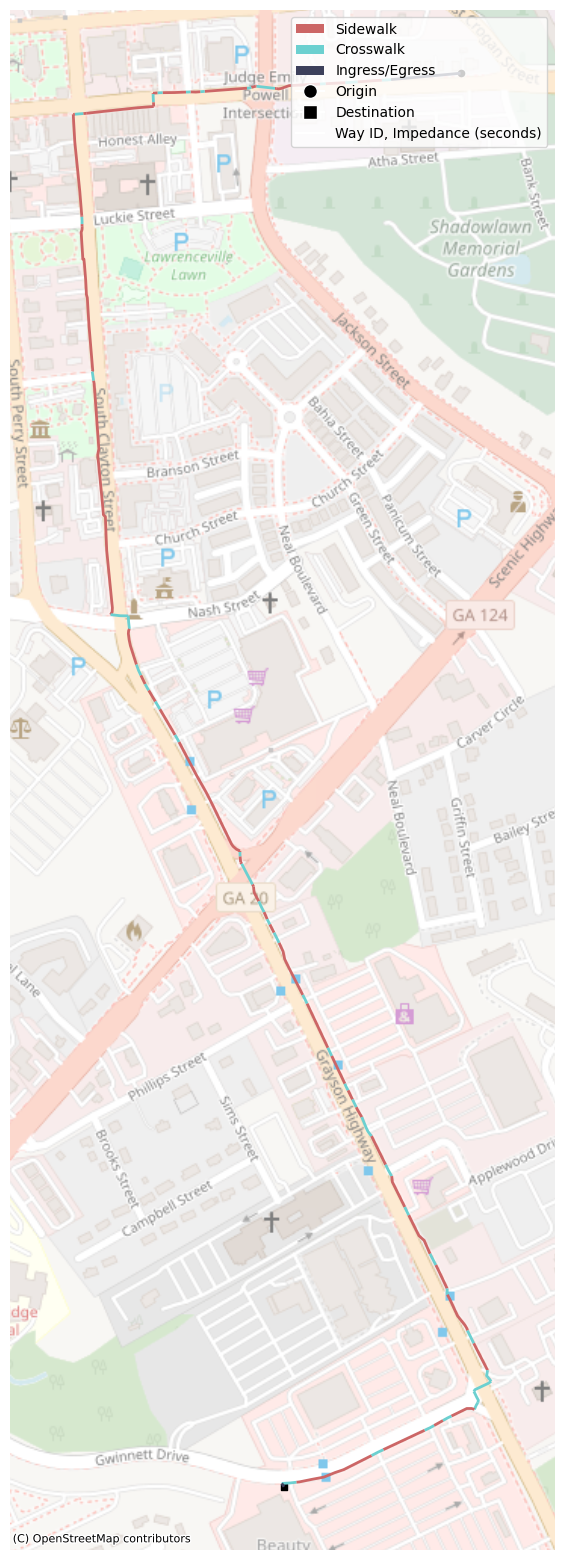

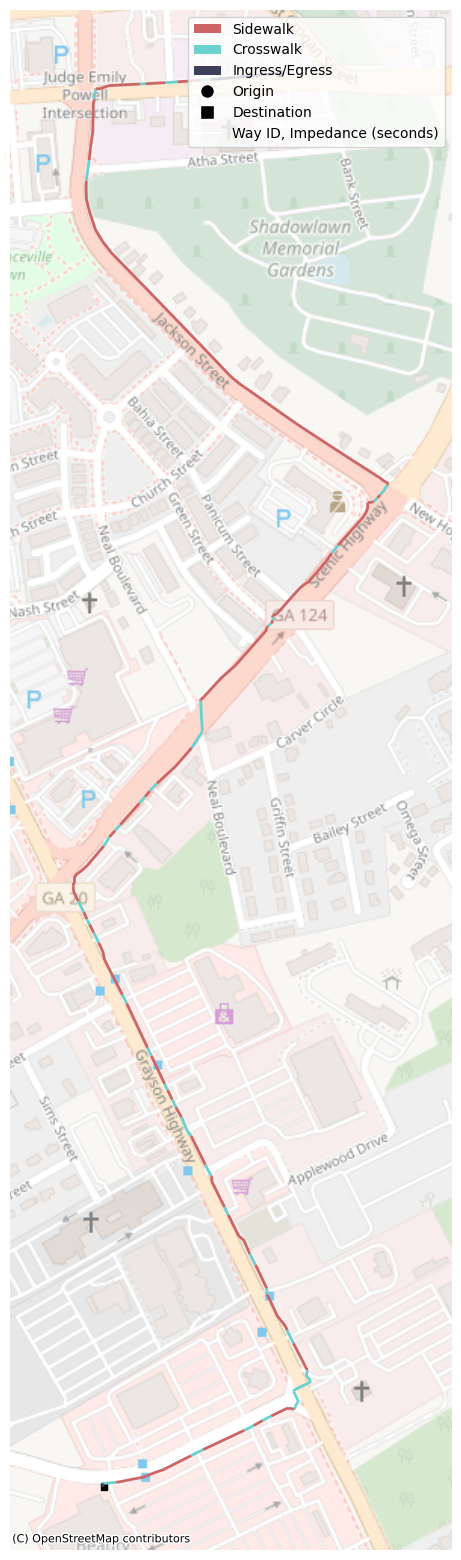

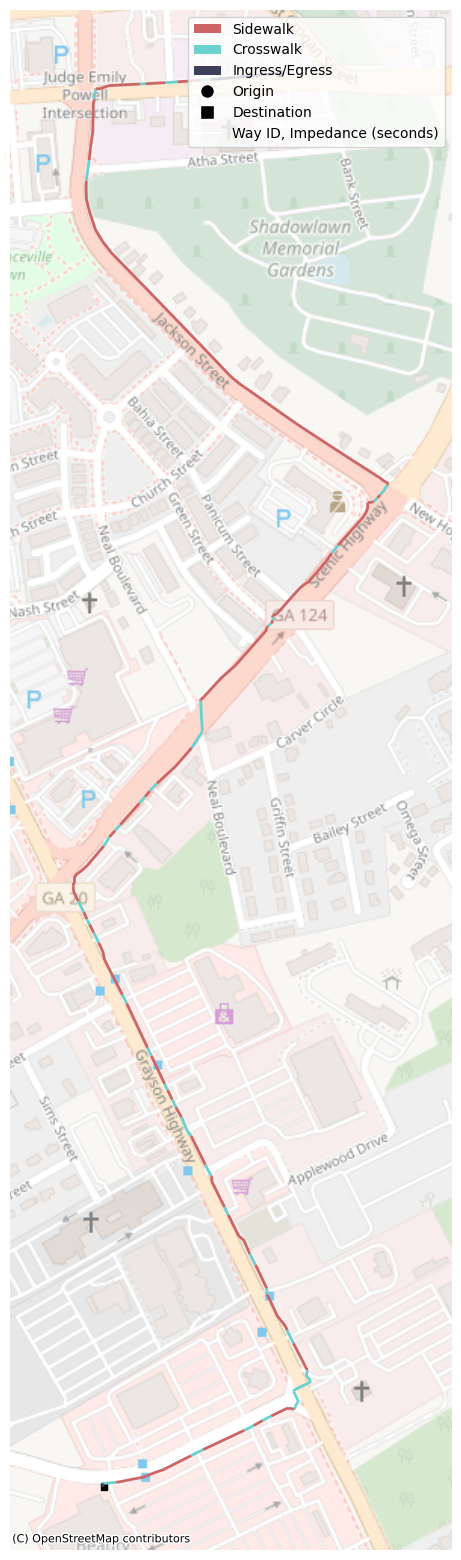

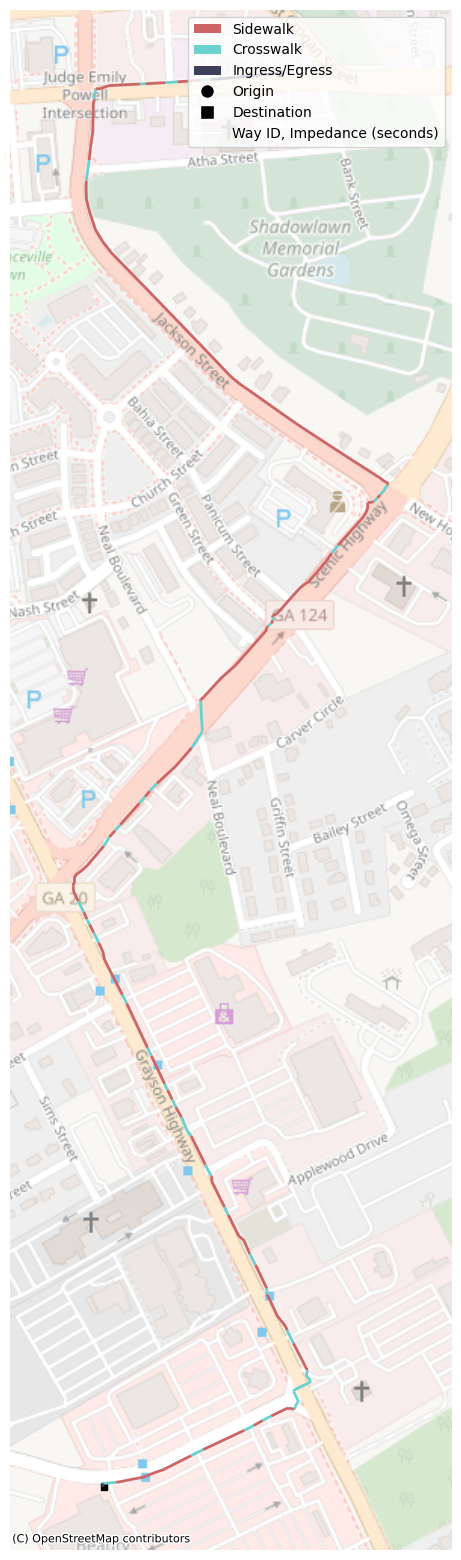

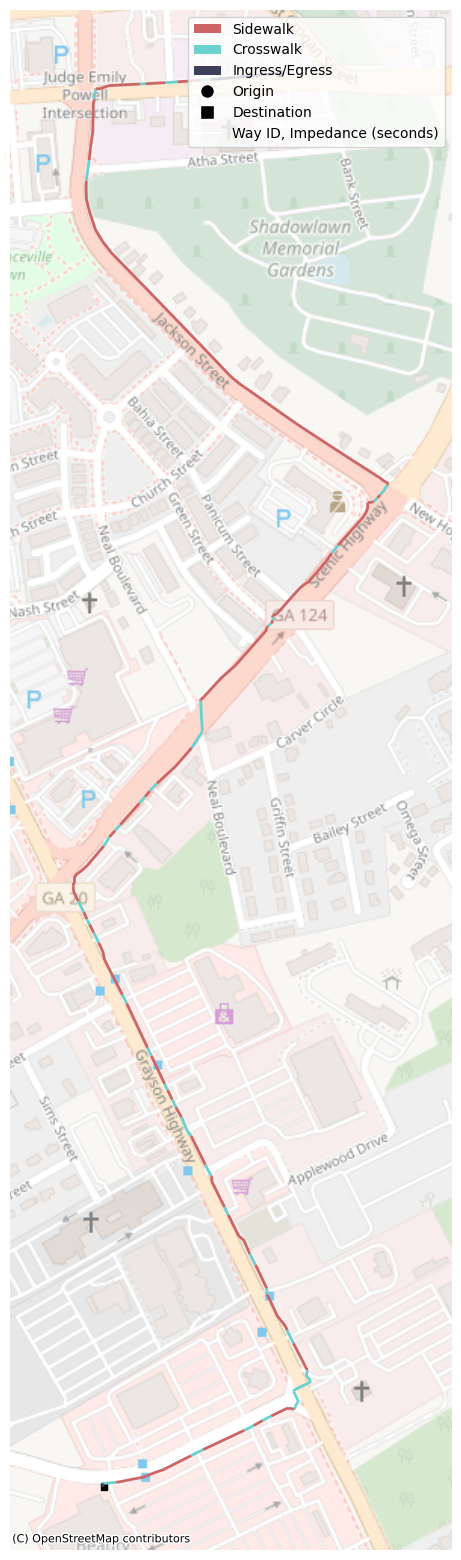

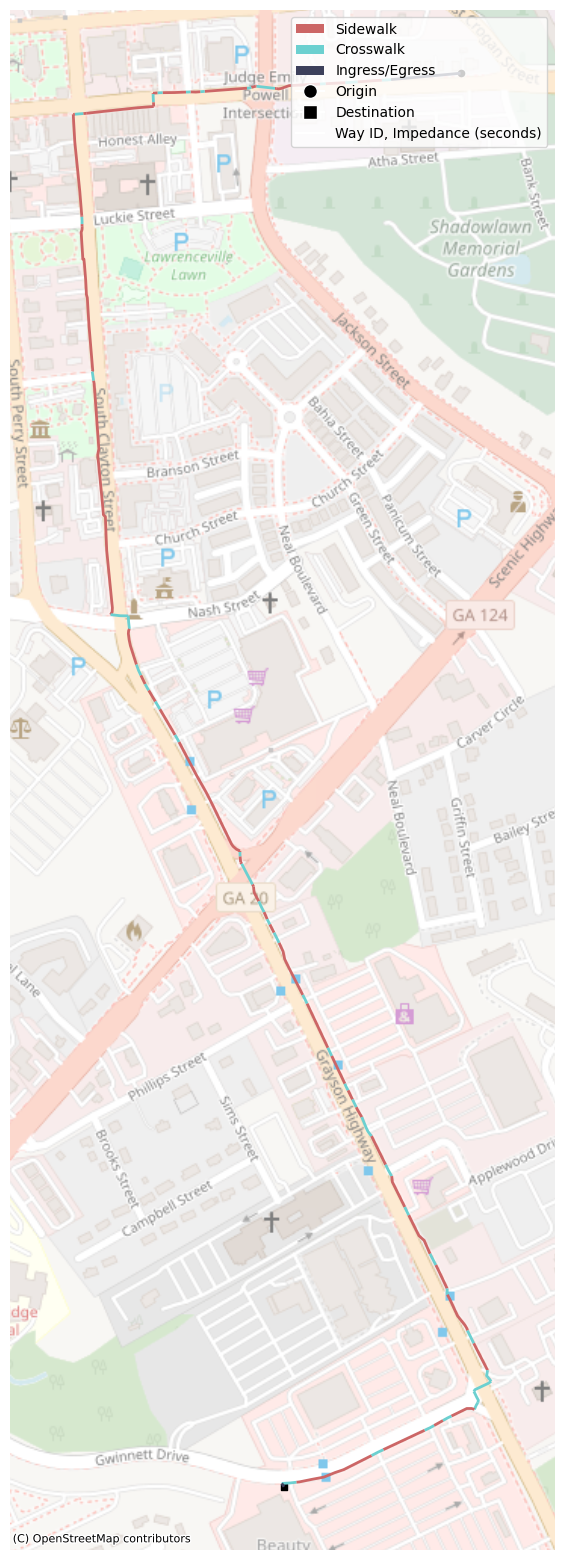

In [48]:
# Define color map for modes
color_map = {
    "sidewalk": '#cc6666',  # Reddish
    "crosswalk": '#6CD0D0',  # Cyan
    "ingress": '#3d405b',  # Dark blue
    "egress": '#3d405b'  # Same as ingress
}

# Define if need to save shapefile
saveShp = True

# Find all trips
p_trips = glob.glob(os.path.join(os.environ['PROJ_LIB'], 'build_graph/samples_out/*.csv'))
df_trips = [pd.read_csv(p) for p in p_trips]
df_trips = pd.concat(df_trips, ignore_index=True)

# Iterate over impedance columns
if not use_impedance: 
    cols = [''] # Define empty colname if not using impedance
for col in cols:

    saveLoc = os.path.join(os.environ['PROJ_LIB'], 'build_graph/results_route_polished/{}'.format(col))
    os.makedirs(saveLoc, exist_ok=True)

    if saveShp:
        os.makedirs(saveLoc.replace('results_route_polished', 'results_route_shp'), exist_ok=True)

    # Iterate over all trips
    for ind, row in tqdm(df_trips.iterrows(), total=df_trips.shape[0]):

        # Import trajectory file
        df_traj = pd.read_csv(os.path.join(os.environ['PROJ_LIB'], 'build_graph/results', col, 'paths_walk_{}.csv'.format(str(row['trip_id']))))
        
        if df_traj.shape[0] == 0:
            continue

        # Get in-walk geometries
        df_traj = df_traj.drop(columns='mode') # replace the original mode with updated information in df_links
        df_traj = df_traj.merge(df_links, how='left', on=['A','B'])
        
        # Get origin-in and out-destination trajectory
        mask = (nodes['node'] == df_traj.iloc[0]['B'])
        o_node_coord = (float(nodes[mask].lon), float(nodes[mask].lat))
        #
        mask = (nodes['node'] == df_traj.iloc[-1]['A'])
        d_node_coord = (float(nodes[mask].lon), float(nodes[mask].lat))
        #
        o_coord = (row.ori_lon, row.ori_lat)
        d_coord = (row.dest_lon, row.dest_lat)
        #
        df_traj.iloc[0, df_traj.columns.get_loc('geometry')] = LineString([o_coord, o_node_coord])
        df_traj.iloc[-1, df_traj.columns.get_loc('geometry')] = LineString([d_node_coord, d_coord])
        df_traj.iloc[0, df_traj.columns.get_loc('mode')] = 'ingress'
        df_traj.iloc[-1, df_traj.columns.get_loc('mode')] = 'egress'
        df_traj.iloc[0, df_traj.columns.get_loc('Way Id')] = 'Connector'
        df_traj.iloc[-1, df_traj.columns.get_loc('Way Id')] = 'Connector'

        # Plot it
        plot_polished_sws_traj(df_traj, color_map, saveLoc, saveShp)

## Other Modules

1. Given arrival time at destination, solve latest departure time.
2. Give different impedance (cost) to different sidewalk links, e.g., presence vs. absence, slope, quality of sidewalk, etc.
3. Allow fast trip-level result retrieval.